<a href="https://colab.research.google.com/github/pachterlab/FGP_2023/blob/main/BIC_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fit parameters to ATAC-seq data and compare the explanatory power of models with and without site-site correlations.

#### Function Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

import numpy as np
import multiprocessing
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution

from FGP_2023.simulation import analytic_ss
from FGP_2023.noise import get_combos, Ising_analytic_drop, Ising_analytic_ss, dist_drop
from FGP_2023.construct_H import Ising_steady_state

Mounted at /content/drive
Package FGP_2023 is being imported!


## Import pre-processed data for analysis.
We use distribution information at pre-selected ATAC-seq loci. This information is in the form of a dictionary, where the keys index the chromosomal location of a six-site locus, and the values are cell distributions at that locus. The cell distributions also take the form of a dictionary, where the keys represent the openness of the six sites at the locus, e.g. (101011), and the values represent the number of cells which had this configuration at the locus.

In [ ]:
## Set dataset to the desired value to control which data is imported.
# Choose 'PBMCs', 'mouse_cortex' or 'human_mouse'
dataset = 'mouse_cortex'

transcript_files = {'human_mouse': 'human_mouse_mixture/transcripts_hum_mouse_mixture.txt',
                    'mouse_cortex': 'mouse_cortex/transcripts.txt', 'PBMCs': 'PBMCs/transcripts.txt' }
data_files = {'human_mouse': {'mouse':'human_mouse_mixture/mixed_mouse_dist_dict.pkl', 'human':'human_mouse_mixture/mixed_human_dist_dict.pkl'},
              'mouse_cortex': 'mouse_cortex/mouse_cortex_dist_dict.pkl', 'PBMCs': 'PBMCs/dist_dict.pkl'}
file_location = '/content/drive/MyDrive/Colab Notebooks/FGP_2023/'


In [ ]:
## Import chromosomal location information.
transcript_file = file_location + transcript_files[dataset]
df_transcripts = pd.read_csv (transcript_file, '\t', skiprows=0, skipinitialspace=True, header=None)
df_transcripts.columns = ['location']
df_transcripts.index.name = 'transcript'
df_transcripts.index = df_transcripts.index+1

<ipython-input-4-e5a7586d5b37>:3: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  df_transcripts = pd.read_csv (transcript_file, '\t', skiprows=0, skipinitialspace=True, header=None)


In [ ]:
## Sort loci into human and mouse genomes.
if dataset == 'human_mouse':

  with open(file_location + data_files[dataset]['mouse'], 'rb') as fp:
    mouse_dist_dict = pickle.load(fp)

  with open(file_location + data_files[dataset]['human'], 'rb') as fp:
    human_dist_dict = pickle.load(fp)

  human_loci, mouse_loci = [], []
  for key in human_dist_dict.keys():
      loc_string = df_transcripts.loc[key[0]]['location'].split('-')[0]+ '-' + df_transcripts.loc[key[-1]]['location'].split('-')[1]
      if loc_string.startswith('h'):
          human_loci += [key]
      elif loc_string.startswith('m'):
          mouse_loci += [key]
      else:
          print('Genomic location not recognized.')

  loci_keys = human_loci + mouse_loci
  loci_dists = {}
  for key in human_loci:
    loci_dists[key] = human_dist_dict[key]
  for key in mouse_loci:
    loci_dists[key] = mouse_dist_dict[key]

else:

  dist_file = file_location + data_files[dataset]
  with open(dist_file, 'rb') as fp:
    loci_dists = pickle.load(fp)
  loci_keys = [i for i in loci_dists.keys()]

## Define model distributions and log-likelihood calculations for model fitting.

In [ ]:
## Model Inference
def Ising_steady_state_dist(k_ons, k_off, epsilon):

    n = len(k_ons)
    combos = get_combos(n)
    probs = Ising_steady_state(k_ons, k_off, epsilon)
    dist = {}
    for combo, prob in zip(combos, probs):
      dist[tuple(combo)] = prob
    return dist


def LL(observed_dist, analytic_dist):

    LogL = 0
    for k in analytic_dist.keys():
        LogL += -np.log(analytic_dist[k])*observed_dist[k]
    return LogL

def BIC(n, k, log_likelihood, normalized=True):
    # Assume that empirical distribution had been normalized to 1.
    if normalized:
        return k*np.log(n) - 2*log_likelihood*n
    else:
        return k*np.log(n) - 2*log_likelihood

def model_6_params(params):

    k_ons = [10**i for i in params]
    # NB k_ons are in units of k_off so we set k_off = 1
    k_off, epsilon = 1, 1

    steady_state = analytic_ss(k_ons, k_off, epsilon)

    # Convert from gene-state indices to site openesses for six-site locus.
    combos = get_combos(6)
    analytic_dist = {tuple(combos[i]): steady_state[i] for i in range(len(steady_state))}

    return analytic_dist

def model_8_params(params):

    epsilon = 10**params[0]
    pdrop = 10**params[-1]
    k_ons = [10**i for i in params[1:-1]]

    # NB k_ons are in units of k_off so we set k_off = 1
    k_off= 1
# dist_drop(distribution, args, kwargs, drop)
    analytic_dist = dist_drop(Ising_steady_state_dist, [k_ons, k_off, epsilon], {}, pdrop)

    # analytic_dist = Ising_analytic_drop(k_ons, k_off, epsilon, pdrop)

    return analytic_dist


def LL_6_param(params, obs_dist):
    '''
    Function to optimize for the 6-parameter model.
    '''
    analytic_dist = model_6_params(params)

    return LL(obs_dist, analytic_dist)

def LL_8_param(params, obs_dist):
    '''
    Function to optimize for the 8-parameter model.
    '''
    analytic_dist = model_8_params(params)

    return LL(obs_dist, analytic_dist)

## Fit parameters for each locus.

In [ ]:
## Fit the model to all loci.
results = {}
workers = 32
bounds_6 = [(-3,3)]*6
bounds_8 = [(-3,3)]*7+[(-6,-0.01)] #[(-2,2)]*7 + [(-4,-0.01)]
atol, tol = 1e-10, 1e-10

## Add human info to results.
for key in loci_keys:

    loc_string = df_transcripts.loc[key[0]]['location'].split('-')[0]+ '-' + df_transcripts.loc[key[-1]]['location'].split('-')[1]
    print(loc_string)

    observed_dist = loci_dists[key]
    total_cells = sum(observed_dist.values())
    av_mean = sum([np.mean(key)*value/total_cells for key,value in observed_dist.items()])

    result_8 = differential_evolution(LL_8_param, bounds_8, args=([observed_dist]),init='random', tol=tol, atol=atol, workers=workers)
    result_6 = differential_evolution(LL_6_param, bounds_6, args=([observed_dist]),init='random', tol=tol, atol=atol, workers=workers)

    BIC_6 = BIC(total_cells, 6, -result_6.fun, normalized=False)
    BIC_8 = BIC(total_cells, 8, -result_8.fun, normalized=False)

    results[key] = {'result_6': result_6, 'result_8': result_8, 'BIC_6': BIC_6, 'BIC_8': BIC_8, 'av_mean':av_mean}

1:172134032-172157528


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentialevolution.py:387: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


11:120119474-120131466
13:83802715-83809701
15:27783188-27795411
15:85551572-85565581
7:101099140-101110619
9:43990069-44006338


## Plot BIC difference between eight-parameter and six-parameter model fits at each locus.

<ipython-input-9-2ac1c19cc35c>:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  colors = [color1*(i<0)+color2*(i>0) for i in BIC_diffs]


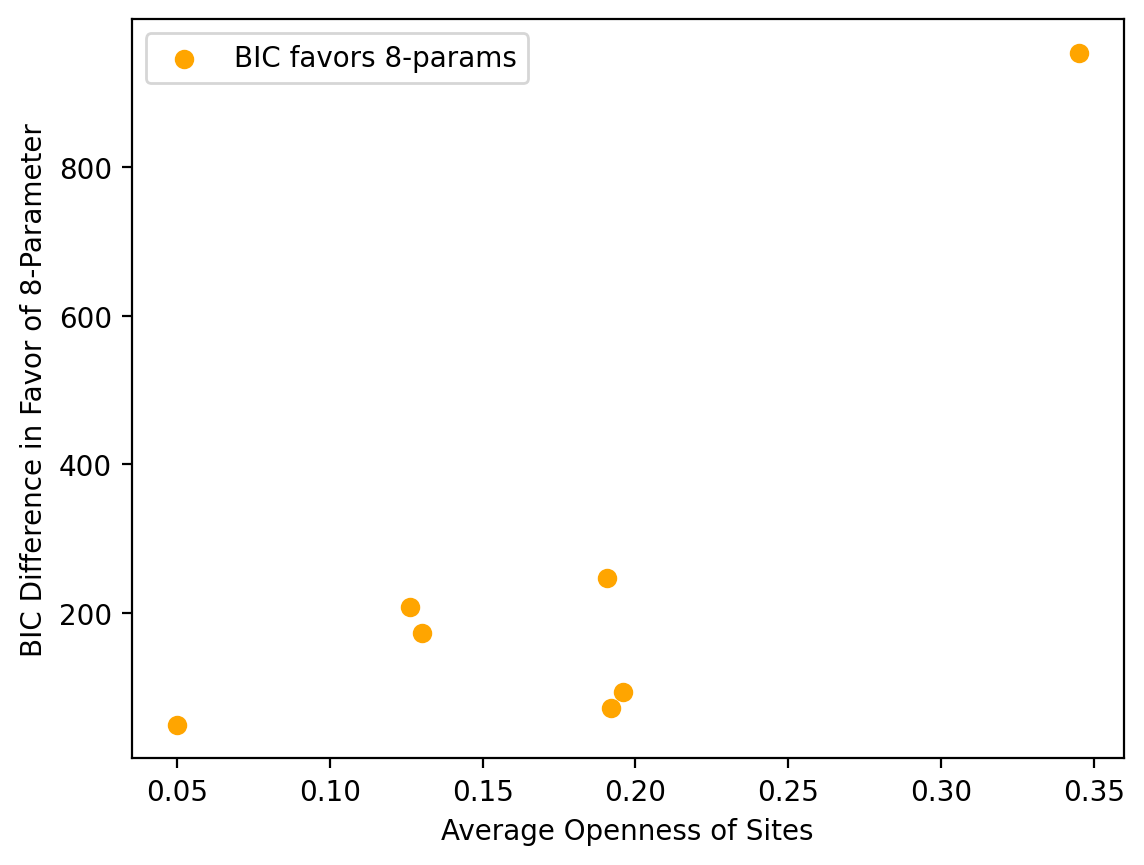

In [ ]:
## Plot BIC preference for model with site-site correlations, as in figure 4 of the main text.

color1 = 'blue'
color2 = 'orange'

locations, BIC_diffs, av_means = [], [], []
for key in results.keys():

    # Find chromosomal location of this 6-site locus.
    loc_string = df_transcripts.loc[key[0]]['location'].split('-')[0]+ '-' + df_transcripts.loc[key[-1]]['location'].split('-')[1]

    locations += [loc_string]
    BIC_diffs += [results[key]['BIC_6'] - results[key]['BIC_8']]
    av_means += [results[key]['av_mean']]

# Color based on which model is prefered.
colors = [color1*(i<0)+color2*(i>0) for i in BIC_diffs]

fig, ax = plt.subplots()
# plt.yscale('log')
# ax.scatter(av_means, BIC_diffs, c=colors)
labels = {color2: 'BIC favors 8-params', color1: 'BIC favors 6-params'}
for g in np.unique(colors):
    i = np.where(np.array(colors) == g)
    ax.scatter(np.array(av_means)[i], np.array(BIC_diffs)[i], label=labels[g], color=g)
# ax.yscale('log')
# plt.title('BIC Preference for Inclusion of Extra Parameters \n vs Average Site Openness')
plt.ylabel('BIC Difference in Favor of 8-Parameter')
plt.xlabel('Average Openness of Sites')

# # Uncomment to label the locations for each comparison.
# for i, txt in enumerate(locations):
#     ax.annotate(txt, (av_means[i], BIC_diffs[i]))

plt.legend()
plt.show()

## Plot observed vs predicted distributions for one fitted locus.

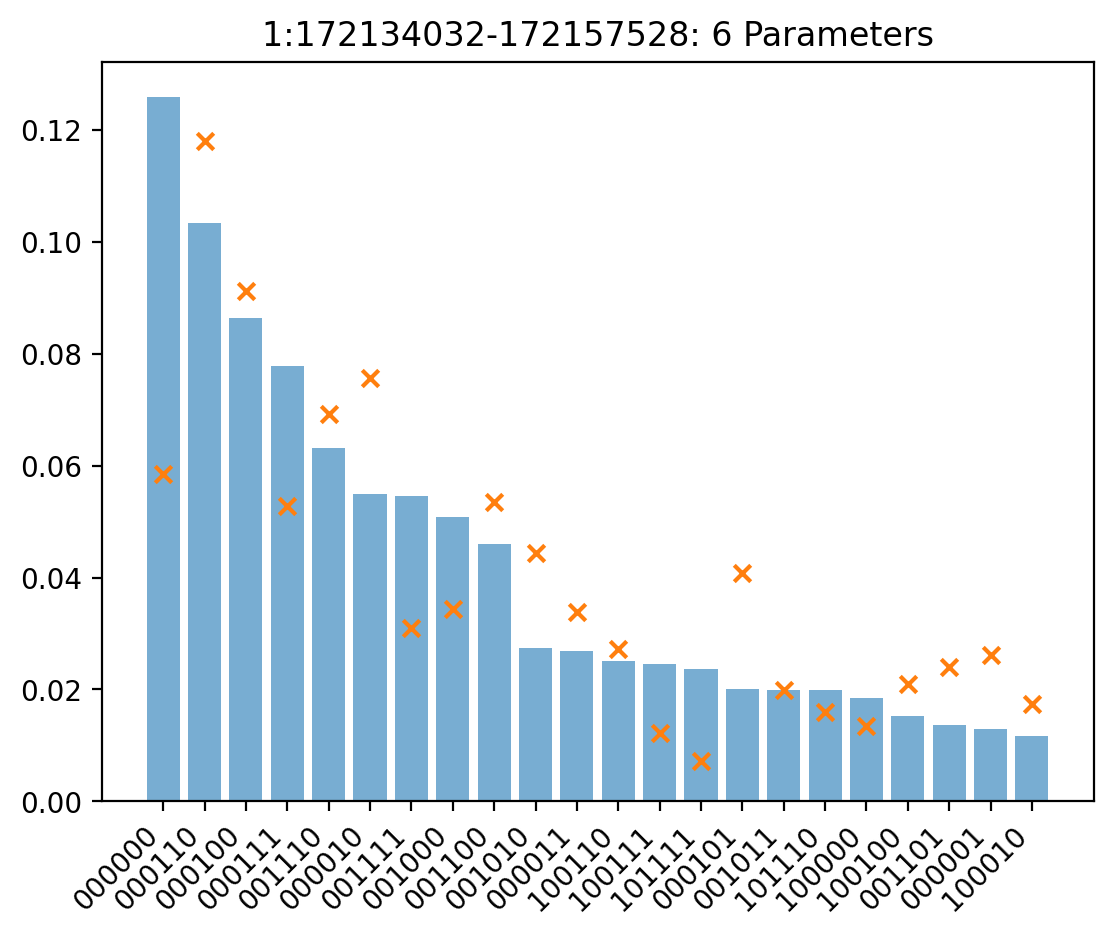

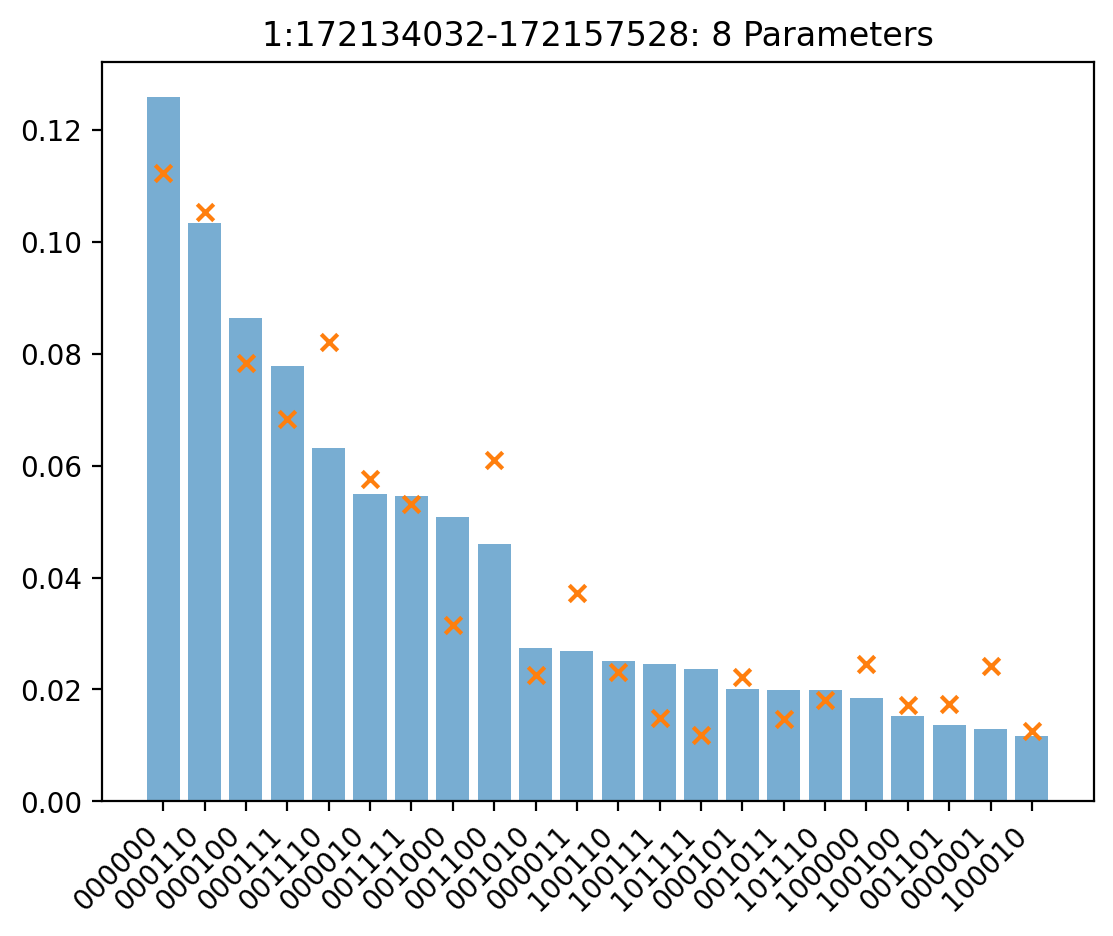

In [ ]:
## Retrieve observed distribution and chromosomal location for one locus.
index = 0
key = loci_keys[index]
obs_dist = loci_dists[key]
loc_string = df_transcripts.loc[key[0]]['location'].split('-')[0]+ '-' + df_transcripts.loc[key[-1]]['location'].split('-')[1]
# Normalize observed distribution.
total_cells = sum(obs_dist.values())
obs_dist = {k:v/total_cells for k,v in obs_dist.items()}

## Plot 6-parameter fit.
pred_params = results[key]['result_6']['x']
pred_dist = model_6_params(pred_params)

## Repeat plotting for highest n probabilities.
include_num_bars = 22
top_7_keys =  sorted(obs_dist, key=obs_dist.get, reverse=True)[:include_num_bars]
top_7_labels = [''.join([str(j) for j in i]) for i in top_7_keys]

# Bar chart of the simulated sample.
plt.bar(top_7_labels, [obs_dist[i] for i in top_7_keys], alpha=0.6, label='data')

# Scatter plot of probability distributions based on fitted and real parameters.
plt.scatter(top_7_labels, [pred_dist[i] for i in top_7_keys], s=35, label='fitted distribution', marker='x')
plt.xticks(rotation=45, ha="right")
plt.title(loc_string + ': 6 Parameters')
plt.show()

## Plot 8-parameter fit.
pred_params = results[key]['result_8']['x']
pred_dist = model_8_params(pred_params)

## Repeat plotting for highest n probabilities.
include_num_bars = 22
top_7_keys =  sorted(obs_dist, key=obs_dist.get, reverse=True)[:include_num_bars]
top_7_labels = [''.join([str(j) for j in i]) for i in top_7_keys]

# Bar chart of the simulated sample.
plt.bar(top_7_labels, [obs_dist[i] for i in top_7_keys], alpha=0.6, label='data')

# Scatter plot of probability distributions based on fitted and real parameters.
plt.scatter(top_7_labels, [pred_dist[i] for i in top_7_keys], s=35, label='fitted distribution', marker='x')
plt.xticks(rotation=45, ha="right")
plt.title(loc_string + ': 8 Parameters')
plt.show()